In [1]:
import numpy as np; import pandas as pd; import pyodbc; import datetime; import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn import metrics
from sklearn.random_projection import GaussianRandomProjection,SparseRandomProjection
from sklearn.decomposition import PCA, FastICA,TruncatedSVD
%pylab inline 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:90% !important;}</style>"))

conn = pyodbc.connect(r'DRIVER={SQL Server Native Client 11.0};'r'SERVER=WIN-5G5AUOCEJPK;'r'DATABASE=Gold585;'r'Trusted_Connection=yes;')

Populating the interactive namespace from numpy and matplotlib


необходимые таблицы для прогноза - TempPurch3 и TempDate

In [2]:
%%time
sql_query ="SELECT a.[PurchaseDate] \
      ,MONTH(a.[PurchaseDate]) Month \
      ,a.[PartnerID] \
      ,IIF(SEX='M',1,0) SEX \
      ,IIF(DATEDIFF(YEAR,[BirthDate],a.[PurchaseDate])> 100 , 0 , DATEDIFF(YEAR,[BirthDate],a.[PurchaseDate])) Age \
      ,[CityID] \
      ,DATEDIFF(DAY, [FirstVisit],a.[PurchaseDate])/30.0 LT  \
      ,DATEDIFF(DAY, t.LastDate,a.[PurchaseDate])/30.0 LastVisit_M  \
      ,[FirstVisit] \
      ,[QNTVisits] \
      ,[SumSMS] \
      ,[SumQuantity] \
      ,[SumSumma] \
      ,[AVGSumma] \
      ,[SUMM1] \
      ,[SUMM2] \
      ,[SUMM3] \
      ,[SUMM4] \
      ,[SUMM5] \
      ,[SUMM6] \
      ,[SUMM7] \
      ,[SUMM8] \
      ,[SUMM9] \
      ,[SUMM10] \
      ,[SUMM11] \
      ,[SUMM12] \
      ,[SUMP1k] \
      ,[SUMP3k] \
      ,[SUMP6k] \
      ,[SUMP12k] \
      ,[SUMP50k] \
      ,[SUMKolco] \
      ,[SUMSERGI] \
      ,[SUMPODVES] \
      ,[SUMCEP] \
      ,[SUMBRASLET] \
      ,[SUMKOLE] \
      ,[SUMCheap] \
      ,[SUMExpensive] \
      ,[SUMPremium] \
      ,[SUMMiddle] \
      ,[SUMZoloto] \
      ,[SUMSerebro] \
      ,[SUMColorBlack] \
      ,[SUMColorRed] \
      ,[SUMColorYellow] \
      ,[SUMColorWhite] \
      ,[SUMColor3] \
      ,[SUMColor2] \
      ,[SUMGroupBaza] \
      ,[SUMGroupClassic] \
      ,[SUMGroupModa] \
      ,[SUMGroupModul] \
      ,[SUMGroupSouvenir] \
      ,[SUMGroupTrend] \
      ,IIF(LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID,0,1) LastPurchase \
      ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMZoloto],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMZoloto] IS NULL,0,1)), \
      1,0) NextGold \
      ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMKolco],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMKolco] IS NULL,0,1)), \
      1,0) NextColco \
      ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMSERGI],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMSERGI] IS NULL,0,1)), \
      1,0) NextSERGI \
      ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMPODVES],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMPODVES] IS NULL,0,1)), \
	  1,0) NextPODVES \
	  ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMCEP],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMCEP] IS NULL,0,1)), \
	  1,0) NextCEP \
	  ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMBRASLET],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMBRASLET] IS NULL,0,1)), \
	  1,0) NextBRASLET \
	  ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMCheap],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMCheap] IS NULL,0,1)), \
	  1,0) NextCheap \
	  ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMExpensive],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMExpensive] IS NULL,0,1)), \
	  1,0) NextExpensive \
	  ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMMiddle],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMMiddle] IS NULL,0,1)), \
	  1,0) NextMiddle \
  FROM [Gold585].[dbo].[TempPurch3] a left join [Gold585].[dbo].TempDate2 t on a.PartnerID = t.PartnerID and a.PurchaseDate = t.PurchaseDate \
  order by PartnerID, PurchaseDate"

df = pd.read_sql(sql_query,conn)
df.head()

Wall time: 16min 13s


In [3]:
pred = df[df['LastPurchase']==1].fillna(0).reset_index(drop=True)
predId = pd.DataFrame(df['PartnerID'][df['LastPurchase']==1],columns=['PartnerID']).reset_index(drop=True)
data = df[df['LastPurchase']!=1].fillna(0).reset_index(drop=True)
pred.head()

,PurchaseDate,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,FirstVisit,QNTVisits,...,LastPurchase,NextGold,NextColco,NextSERGI,NextPODVES,NextCEP,NextBRASLET,NextCheap,NextExpensive,NextMiddle
0,2016-01-24,1,2,0,46,35,0.000000,0.000000,2016-01-24,1,...,1,0,0,0,0,0,0,0,0,0
1,2016-01-24,1,3,1,49,72,0.000000,0.000000,2016-01-24,1,...,1,0,0,0,0,0,0,0,0,0
2,2018-08-25,8,4,0,0,92,20.733333,0.100000,2016-12-11,8,...,1,0,0,0,0,0,0,0,0,0
3,2017-01-14,1,6,0,31,32,11.866666,11.866666,2016-01-24,2,...,1,0,0,0,0,0,0,0,0,0
4,2016-01-24,1,9,0,0,122,0.000000,0.000000,2016-01-24,1,...,1,0,0,0,0,0,0,0,0,0


In [4]:
data.shape

(5697650, 65)

In [5]:
print(data['NextCheap'].value_counts())
print(data['NextExpensive'].value_counts())
print(data['NextMiddle'].value_counts())

1    3375304
0    2322346
Name: NextCheap, dtype: int64
0    3289671
1    2407979
Name: NextExpensive, dtype: int64
0    3023529
1    2674121
Name: NextMiddle, dtype: int64


In [6]:
data.columns

Index(['PurchaseDate', 'Month', 'PartnerID', 'SEX', 'Age', 'CityID', 'LT',
       'LastVisit_M', 'FirstVisit', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4', 'SUMM5',
       'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11', 'SUMM12',
       'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k', 'SUMKolco',
       'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET', 'SUMKOLE', 'SUMCheap',
       'SUMExpensive', 'SUMPremium', 'SUMMiddle', 'SUMZoloto', 'SUMSerebro',
       'SUMColorBlack', 'SUMColorRed', 'SUMColorYellow', 'SUMColorWhite',
       'SUMColor3', 'SUMColor2', 'SUMGroupBaza', 'SUMGroupClassic',
       'SUMGroupModa', 'SUMGroupModul', 'SUMGroupSouvenir', 'SUMGroupTrend',
       'LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],
      dtype='object')

In [7]:
#dataColco1 = data[data['NextColco']==1] #.sample(300000)
#dataSERGI1 = data[data['NextSERGI']==1]
#dataPODVES1 = data[data['NextPODVES']==1]
#dataCEP1 = data[data['NextCEP']==1]
#dataBRASLET1 = data[data['NextBRASLET']==1]

#dataColco0 = data[data['NextColco']!=1]
#dataSERGI0 = data[data['NextSERGI']!=1].sample(800000)
#dataPODVES0 = data[data['NextPODVES']!=1].sample(550000)
#dataCEP0 = data[data['NextCEP']!=1].sample(500000)
#dataBRASLET0 = data[data['NextBRASLET']!=1].sample(300000)

X = data
#X = pd.concat([dataColco1,dataColco0],axis=0,ignore_index=True)
#XSERGI = pd.concat([dataSERGI1,dataSERGI0],axis=0,ignore_index=True)
#XPODVES = pd.concat([dataPODVES1,dataPODVES0],axis=0,ignore_index=True)
#XCEP = pd.concat([dataCEP1,dataCEP0],axis=0,ignore_index=True)
#XBRASLET = pd.concat([dataBRASLET1,dataBRASLET0],axis=0,ignore_index=True)

X.head()

,PurchaseDate,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,FirstVisit,QNTVisits,...,LastPurchase,NextGold,NextColco,NextSERGI,NextPODVES,NextCEP,NextBRASLET,NextCheap,NextExpensive,NextMiddle
0,2016-12-11,12,4,0,0,92,0.000000,0.000000,2016-12-11,1,...,0,0,1,0,0,0,0,0,0,0
1,2016-12-18,12,4,0,0,92,0.233333,0.233333,2016-12-11,2,...,0,0,1,0,0,0,0,0,0,1
2,2018-02-14,2,4,0,0,92,14.333333,14.100000,2016-12-11,3,...,0,0,1,0,0,0,0,1,0,1
3,2018-06-07,6,4,0,0,92,18.100000,3.766666,2016-12-11,4,...,0,0,1,0,0,0,0,1,1,1
4,2018-07-17,7,4,0,0,92,19.433333,1.333333,2016-12-11,5,...,0,0,1,0,1,0,0,1,1,1


In [8]:
X.shape

(5697650, 65)

In [9]:
X.columns

Index(['PurchaseDate', 'Month', 'PartnerID', 'SEX', 'Age', 'CityID', 'LT',
       'LastVisit_M', 'FirstVisit', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4', 'SUMM5',
       'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11', 'SUMM12',
       'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k', 'SUMKolco',
       'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET', 'SUMKOLE', 'SUMCheap',
       'SUMExpensive', 'SUMPremium', 'SUMMiddle', 'SUMZoloto', 'SUMSerebro',
       'SUMColorBlack', 'SUMColorRed', 'SUMColorYellow', 'SUMColorWhite',
       'SUMColor3', 'SUMColor2', 'SUMGroupBaza', 'SUMGroupClassic',
       'SUMGroupModa', 'SUMGroupModul', 'SUMGroupSouvenir', 'SUMGroupTrend',
       'LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],
      dtype='object')

In [10]:
%%time
#a = X['QNTVisits'].quantile(0.99)
#b = X['SumSumma'].quantile(0.99)
#X = X[X['QNTVisits']<a].reset_index(drop=True)
#X = X[X['SumSumma']<b].reset_index(drop=True)

Wall time: 0 ns


In [11]:
y_Cheap=X['NextCheap']
y_Expensive=X['NextExpensive']
y_Middle=X['NextMiddle']


#all_y_Colco = all_data['NextColco']
#all_y_Sergi = all_data['NextSERGI']
#all_y_PODVES = all_data['NextPODVES']
#all_y_CEP = all_data['NextCEP']
#all_y_BRASLET = all_data['NextBRASLET']

X.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)
#XSERGI.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
#       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)
#XPODVES.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
#       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)
#XCEP.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
#       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)
#XBRASLET.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
#       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)

#all_data.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
#       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)

pred.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)

In [12]:
print(X.shape)
print(len(y_Cheap))
#print(all_data.shape)
#print(len(all_y_Colco))
print(pred.shape)

(5697650, 53)
5697650
(4339953, 53)


In [13]:
X.head()

,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,...,SUMColorYellow,SUMColorWhite,SUMColor3,SUMColor2,SUMGroupBaza,SUMGroupClassic,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend
0,12,4,0,0,92,0.000000,0.000000,1,1,1.0,...,0,1,0,0,0,1,0,0,0,0
1,12,4,0,0,92,0.233333,0.233333,2,2,2.0,...,0,2,0,0,0,2,0,0,0,0
2,2,4,0,0,92,14.333333,14.100000,3,3,3.0,...,0,3,0,0,0,3,0,0,0,0
3,6,4,0,0,92,18.100000,3.766666,4,4,5.0,...,0,4,0,0,2,3,0,0,0,0
4,7,4,0,0,92,19.433333,1.333333,5,5,7.0,...,0,5,0,0,2,3,0,1,0,0


In [14]:
%%time
for_norm = pd.concat((X,pred),axis=0,ignore_index=True)

#for_norm_s = pd.concat((XSERGI,pred),axis=0,ignore_index=True)
#for_norm_p = pd.concat((XPODVES,pred),axis=0,ignore_index=True)
#for_norm_c = pd.concat((XCEP,pred),axis=0,ignore_index=True)
#for_norm_b = pd.concat((XBRASLET,pred),axis=0,ignore_index=True)

Wall time: 25.7 s


In [15]:
for_norm.columns

Index(['Month', 'PartnerID', 'SEX', 'Age', 'CityID', 'LT', 'LastVisit_M',
       'QNTVisits', 'SumSMS', 'SumQuantity', 'SumSumma', 'AVGSumma', 'SUMM1',
       'SUMM2', 'SUMM3', 'SUMM4', 'SUMM5', 'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9',
       'SUMM10', 'SUMM11', 'SUMM12', 'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k',
       'SUMP50k', 'SUMKolco', 'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET',
       'SUMKOLE', 'SUMCheap', 'SUMExpensive', 'SUMPremium', 'SUMMiddle',
       'SUMZoloto', 'SUMSerebro', 'SUMColorBlack', 'SUMColorRed',
       'SUMColorYellow', 'SUMColorWhite', 'SUMColor3', 'SUMColor2',
       'SUMGroupBaza', 'SUMGroupClassic', 'SUMGroupModa', 'SUMGroupModul',
       'SUMGroupSouvenir', 'SUMGroupTrend'],
      dtype='object')

In [16]:
%%time
for_norm = pd.get_dummies(for_norm, columns = ['CityID'],drop_first=True)

#for_norm_s = pd.get_dummies(for_norm_s, columns = ['SEX','CityID'],drop_first=True)
#for_norm_p = pd.get_dummies(for_norm_p, columns = ['SEX','CityID'],drop_first=True)
#for_norm_c = pd.get_dummies(for_norm_c, columns = ['SEX','CityID'],drop_first=True)
#for_norm_b = pd.get_dummies(for_norm_b, columns = ['SEX','CityID'],drop_first=True)

#all_data = pd.get_dummies(all_data, columns = ['SEX','CityID'],drop_first=True)

Wall time: 1min


In [17]:
print(for_norm.shape)
#print(all_data.shape)

(10037603, 172)


In [18]:
for_norm.head()

,Month,PartnerID,SEX,Age,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,SumSumma,...,CityID_119,CityID_120,CityID_121,CityID_122,CityID_123,CityID_124,CityID_125,CityID_126,CityID_127,CityID_128
0,12,4,0,0,0.000000,0.000000,1,1,1.0,1079.0,...,0,0,0,0,0,0,0,0,0,0
1,12,4,0,0,0.233333,0.233333,2,2,2.0,1568.0,...,0,0,0,0,0,0,0,0,0,0
2,2,4,0,0,14.333333,14.100000,3,3,3.0,2330.0,...,0,0,0,0,0,0,0,0,0,0
3,6,4,0,0,18.100000,3.766666,4,4,5.0,4271.0,...,0,0,0,0,0,0,0,0,0,0
4,7,4,0,0,19.433333,1.333333,5,5,7.0,6061.0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
%%time
scaler = StandardScaler()
scaler.fit(for_norm)
for_norm_2 = scaler.transform(for_norm)

#scaler = StandardScaler()
#scaler.fit(for_norm)
#for_norm_s = scaler.transform(for_norm)
#scaler = StandardScaler()
#scaler.fit(for_norm)
#for_norm_s = scaler.transform(for_norm)
#scaler = StandardScaler()
#scaler.fit(for_norm)
#for_norm_s = scaler.transform(for_norm)
#scaler = StandardScaler()
#scaler.fit(for_norm)
#for_norm_s = scaler.transform(for_norm)

#all_data_2 = scaler.transform(all_data)

Wall time: 3min 4s


In [20]:
for_norm_2= pd.DataFrame(for_norm_2,columns=for_norm.columns)
#all_data = pd.DataFrame(all_data_s,columns=all_data.columns)

In [21]:
X = for_norm_2[:X.shape[0]]
pred = for_norm_2[X.shape[0]:]
print(X.shape)
print(y_Cheap.shape)
#print(all_data.shape)
#print(len(all_y_Colco))
print(pred.shape)

(5697650, 172)
(5697650,)
(4339953, 172)


In [22]:
pd.DataFrame(X).head()

,Month,PartnerID,SEX,Age,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,SumSumma,...,CityID_119,CityID_120,CityID_121,CityID_122,CityID_123,CityID_124,CityID_125,CityID_126,CityID_127,CityID_128
0,1.396518,-1.915216,-0.594161,-2.000977,-0.590236,-0.444100,-0.063751,-0.063751,-0.074903,-0.065164,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
1,1.396518,-1.915216,-0.594161,-2.000977,-0.567486,-0.401696,-0.057716,-0.057716,-0.071701,-0.064859,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
2,-1.378657,-1.915216,-0.594161,-2.000977,0.807259,2.118276,-0.051680,-0.051680,-0.068499,-0.064383,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
3,-0.268587,-1.915216,-0.594161,-2.000977,1.174507,0.240412,-0.045645,-0.045645,-0.062095,-0.063173,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
4,0.008930,-1.915216,-0.594161,-2.000977,1.304507,-0.201795,-0.039610,-0.039610,-0.055691,-0.062056,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694


In [23]:
pred.head()

,Month,PartnerID,SEX,Age,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,SumSumma,...,CityID_119,CityID_120,CityID_121,CityID_122,CityID_123,CityID_124,CityID_125,CityID_126,CityID_127,CityID_128
5697650,-1.656175,-1.915217,-0.594161,0.591489,-0.590236,-0.444100,-0.063751,-0.063751,-0.068499,-0.063142,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
5697651,-1.656175,-1.915216,1.683046,0.760563,-0.590236,-0.444100,-0.063751,-0.063751,-0.071701,-0.065837,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
5697652,0.286448,-1.915216,-0.594161,-2.000977,1.431256,-0.425927,-0.021503,-0.021503,-0.036479,-0.060769,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
5697653,-1.656175,-1.915214,-0.594161,-0.253881,0.566759,1.712415,-0.057716,-0.057716,-0.058893,-0.060253,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
5697654,-1.656175,-1.915213,-0.594161,-2.000977,-0.590236,-0.444100,-0.063751,-0.063751,-0.074903,-0.052545,...,-0.023639,-0.063545,-0.122868,6.888065,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694


In [24]:
#Дешевое

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y_Cheap, test_size=0.25, random_state=42,stratify=y_Cheap,shuffle =True)

In [26]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC1 = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [200, 700],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC1, param_grid=param_grid, cv= 5)
#model.fit(X_train, y_train)
ExTC1.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
#predicted = model.predict(X_test)
predicted = ExTC1.predict_proba(X_test)
labels =  ExTC1.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, labels))
print(metrics.confusion_matrix(expected, labels))
print(roc_auc_score(expected, labels))
print(roc_auc_score(expected, predicted[:,1]))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.86      0.88      0.87    580587
          1       0.91      0.90      0.91    843826

avg / total       0.89      0.89      0.89   1424413

[[509158  71429]
 [ 86116 757710]]
0.8874584252610634
0.9501819344175912
Wall time: 26min 44s


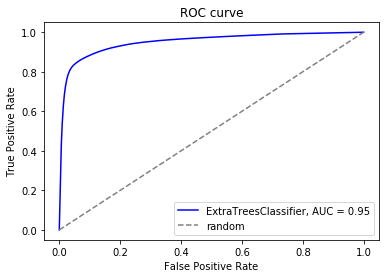

In [29]:
preds = predicted[:,1]
fpr, tpr, treshold = metrics.roc_curve(expected, preds)
roc_auc = metrics.auc(fpr, tpr)
pylab.title('ROC curve')
pylab.plot(fpr, tpr,'b', label = 'ExtraTreesClassifier, AUC = %0.2f' % roc_auc)
pylab.plot([0, 1],[0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.legend(loc = 'lower right')

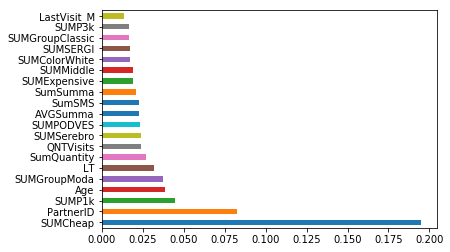

In [30]:
feat_importances = pd.Series(ExTC1.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [31]:
predict = ExTC1.predict_proba(pred)[:,1]
predictedID = pd.concat([predId,pd.DataFrame(predict,columns=['Cheap'])],axis=1,ignore_index=False)

In [32]:
predictedID.head()

,PartnerID,Cheap
0,2,0.350000
1,3,0.000000
2,4,0.980000
3,6,0.911866
4,9,0.060000


In [33]:
#Дорогое

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y_Expensive, test_size=0.25, random_state=42,stratify=y_Expensive,shuffle =True)

In [35]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC2 = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [200, 700],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC2, param_grid=param_grid, cv= 5)
#model.fit(X_train, y_train)
ExTC2.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
#predicted = model.predict(X_test)
predicted = ExTC2.predict_proba(X_test)
labels =  ExTC2.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, labels))
print(metrics.confusion_matrix(expected, labels))
print(roc_auc_score(expected, labels))
print(roc_auc_score(expected, predicted[:,1]))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.91      0.97      0.94    822418
          1       0.95      0.88      0.91    601995

avg / total       0.93      0.93      0.93   1424413

[[796849  25569]
 [ 74749 527246]]
0.922370582483479
0.9717727350902083
Wall time: 33min 50s


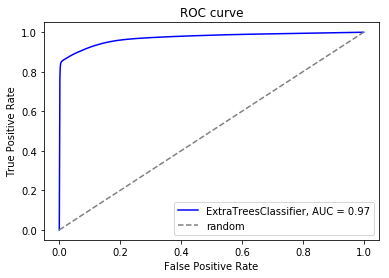

In [36]:
preds = predicted[:,1]
fpr, tpr, treshold = metrics.roc_curve(expected, preds)
roc_auc = metrics.auc(fpr, tpr)
pylab.title('ROC curve')
pylab.plot(fpr, tpr,'b', label = 'ExtraTreesClassifier, AUC = %0.2f' % roc_auc)
pylab.plot([0, 1],[0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.legend(loc = 'lower right')

In [37]:
predict = ExTC2.predict_proba(pred)[:,1]
predictedID = pd.concat([predictedID,pd.DataFrame(predict,columns=['Expensive'])],axis=1,ignore_index=False)
predictedID.head()

,PartnerID,Cheap,Expensive
0,2,0.350000,0.18
1,3,0.000000,0.01
2,4,0.980000,0.80
3,6,0.911866,0.08
4,9,0.060000,0.39


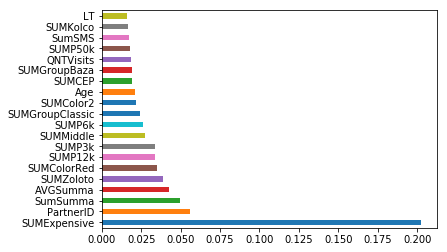

In [38]:
feat_importances = pd.Series(ExTC2.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [39]:
#Средние


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y_Middle, test_size=0.25, random_state=42,stratify=y_Middle,shuffle =True)

In [41]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC3 = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [200, 700],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC3, param_grid=param_grid, cv= 5)
#model.fit(X_train, y_train)
ExTC3.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
#predicted = model.predict(X_test)
predicted = ExTC3.predict_proba(X_test)
labels =  ExTC3.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, labels))
print(metrics.confusion_matrix(expected, labels))
print(roc_auc_score(expected, labels))
print(roc_auc_score(expected, predicted[:,1]))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.89      0.96      0.92    755883
          1       0.95      0.86      0.90    668530

avg / total       0.92      0.91      0.91   1424413

[[725722  30161]
 [ 91945 576585]]
0.9112826135476726
0.9649275485407988
Wall time: 40min 57s


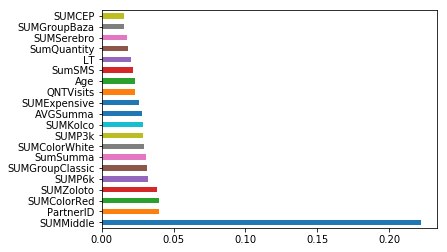

In [42]:
feat_importances = pd.Series(ExTC3.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [43]:
predict = ExTC3.predict_proba(pred)[:,1]
predictedID = pd.concat([predictedID,pd.DataFrame(predict,columns=['Middle'])],axis=1,ignore_index=False)
predictedID.head()

,PartnerID,Cheap,Expensive,Middle
0,2,0.350000,0.18,0.84
1,3,0.000000,0.01,0.01
2,4,0.980000,0.80,0.90
3,6,0.911866,0.08,0.87
4,9,0.060000,0.39,0.11


In [44]:
predictedID.to_csv('PriceSegment_19122018.csv')